In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

## Получение данных

In [3]:
train = pd.read_csv('Training_wells.csv')
train.head()

,Well,X,Y,NTG
0,201-907,201,907,0.2006
1,201-914,201,914,0.3624
2,201-924,201,924,0.4381
3,202-922,202,922,0.4289
4,202-925,202,925,0.4021


In [4]:
test = pd.read_csv('Empty_part.csv')
test.head()

,Well,X,Y
0,201-901,201,901
1,201-902,201,902
2,201-903,201,903
3,201-904,201,904
4,201-905,201,905


## Анализ данных

In [5]:
train.describe()

,X,Y,NTG
count,138.000000,138.000000,138.000000
mean,223.195652,916.630435,0.325720
std,13.590926,8.765456,0.072432
min,201.000000,901.000000,0.177000
25%,211.000000,909.000000,0.270175
50%,222.500000,917.000000,0.325900
75%,236.500000,924.000000,0.377475
max,246.000000,930.000000,0.562500


In [6]:
test.describe()

,X,Y
count,1242.000000,1242.000000
mean,223.533816,915.374396
std,13.250974,8.641061
min,201.000000,901.000000
25%,212.000000,908.000000
50%,224.000000,915.000000
75%,235.000000,923.000000
max,246.000000,930.000000


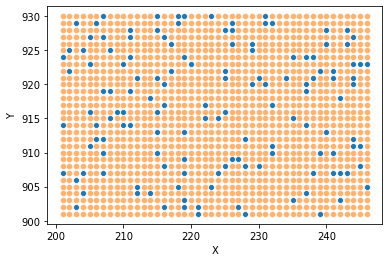

In [13]:
sns.scatterplot(x = train.X, y = train.Y)
sns.scatterplot(x = test.X, y = test.Y, alpha = 0.6)

## Выбор модели

In [14]:
models = [GradientBoostingRegressor(),
         Ridge(),
         KNeighborsRegressor(),
         RandomForestRegressor(),
         ElasticNet()]

name_models = ['GradientBoostingRegressor',
         'Ridge',
         'KNeighborsRegressor',
         'RandomForestRegressor',
              'ElasticNet']

parametrs = [{'learning_rate': [0.1, 0.2, 0.3],
            'n_estimators': [50, 100, 150],
            'max_depth': [4, 5, 6],
            'min_samples_split': [3, 4, 5],
            'min_samples_leaf': [2, 3, 4],
             'max_features': [1, 2]},
            {'alpha': [0.1, 0.5, 1]},
            {'n_jobs': [-1],
            'n_neighbors': [4, 5, 6, 7, 8]},
            {'n_jobs': [-1],
             'n_estimators': [100, 200],
            'max_depth': [4, 5, 6],
            'min_samples_split': [3, 4, 5],
            'min_samples_leaf': [2, 3, 4]},
            {'alpha': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 1]}]

scores = []

X = train[['X', 'Y']]
y = train.NTG

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = 4)

for i in range(0,5,1):

    model = models[i]
    GSR = GridSearchCV(models[i], param_grid=parametrs[i])
    cv = KFold(n_splits=4, shuffle=True, random_state=4)
    cross = cross_val_score(GSR, X, y, cv=cv, n_jobs=-1, scoring='neg_mean_squared_error')
    GSR.fit(xtrain, ytrain)
    mse = mean_squared_error(GSR.best_estimator_.predict(xtest), ytest)
    mse1 = mean_squared_error(GSR.best_estimator_.predict(xtrain), ytrain)
    print('=================================')
    print('cross_val_score: ', np.mean(-cross))
    print(name_models[i])
    print(GSR.best_params_)
    print('train: ', mse1)
    print('test: ', mse)
    print('score: ', GSR.score(xtrain, ytrain))

cross_val_score:  0.0031797687557498736
GradientBoostingRegressor
{'learning_rate': 0.1, 'max_depth': 5, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 100}
train:  0.00023778282098430245
test:  0.0035699501665014126
score:  0.9574928020829133
cross_val_score:  0.005322058023474261
Ridge
{'alpha': 1}
train:  0.005447204865825363
test:  0.00414695938219767
score:  0.02623152350504776
cross_val_score:  0.0041305646669334405
KNeighborsRegressor
{'n_jobs': -1, 'n_neighbors': 5}
train:  0.0024784234181818177
test:  0.0037071672857142864
score:  0.5569451387493136
cross_val_score:  0.0037485512849254462
RandomForestRegressor
{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 100, 'n_jobs': -1}
train:  0.0017248863155895045
test:  0.003367196251684732
score:  0.6916510465401629
cross_val_score:  0.005239520850025129
ElasticNet
{'alpha': 0.1}
train:  0.0054963716284490895
test:  0.003901532893438938
score:  0.017442237125410154


## Решение

In [16]:
def well(x, y):
    return str(int(x)) + '-' + str(int(y))

In [25]:
tmp = train.copy()

while tmp.shape[0] < 1380:
    values = []

    for i in tmp.index:
        values.append([tmp.X[i], tmp.Y[i]])

    one_test = []

    for i in tmp.index:
        if (tmp['X'][i]-1 >= tmp['X'].min()) & ([tmp['X'][i]-1, tmp['Y'][i]] not in values) & ([tmp['X'][i]-1, tmp['Y'][i]] not in one_test):
            one_test.append([tmp['X'][i]-1, tmp['Y'][i]])
            
    if len(one_test) == 0:
        for i in tmp.index:
            if (tmp['X'][i]+1 <= tmp['X'].max()) & ([tmp['X'][i]+1, tmp['Y'][i]] not in values) & ([tmp['X'][i]+1, tmp['Y'][i]] not in one_test):
                one_test.append([tmp['X'][i]+1, tmp['Y'][i]])
    
    one_df = pd.DataFrame(data = one_test, columns=['X', 'Y'])

    # обучение и предсказание

    X = tmp[['X', 'Y']]
    y = tmp.NTG
    
    cv = KFold(n_splits=5, shuffle=True, random_state = 35)
    k = {'n_neighbors': range(3, 10),
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size':[10, 20, 30]}
    knr = KNeighborsRegressor(n_jobs=-1, weights='distance')
    gknr = GridSearchCV(knr, param_grid=k, cv = cv, scoring='neg_mean_squared_error')

    gknr.fit(X, y)
    best_gknr = gknr.best_estimator_
    print(gknr.best_params_)
    one_df['NTG'] = best_gknr.predict(one_df)
    one_df['Well'] = one_df.apply(lambda res: well(res['X'], res['Y']), axis=1)
    tmp = pd.concat([tmp, one_df], axis=0, ignore_index=True)

res = pd.pivot_table(tmp, index='Y', columns='X', values='NTG')
sns.heatmap(res.sort_index(ascending=False), cmap='coolwarm')

KeyboardInterrupt: 

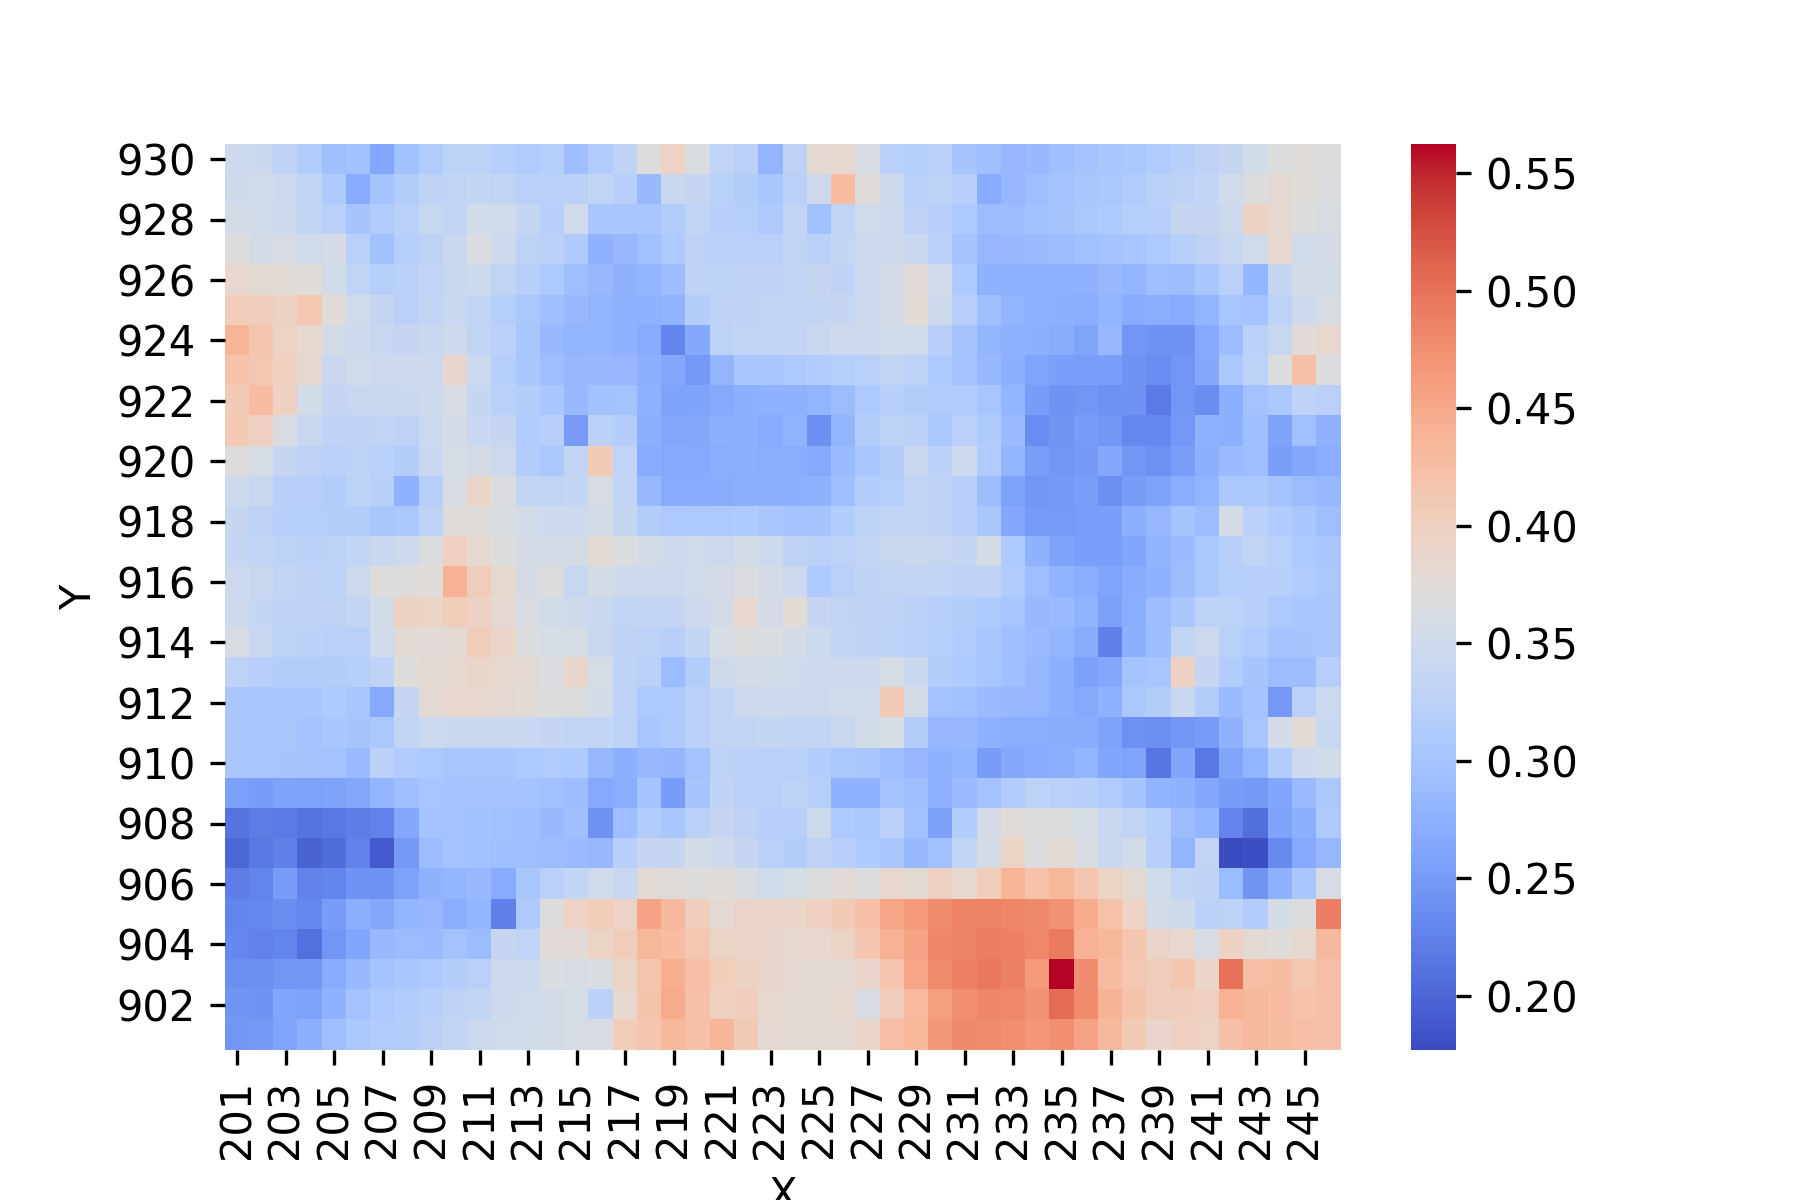

In [30]:
from IPython.display import Image
Image("heatmap.png", width = 600, height = 200)

In [18]:
answer = pd.merge(test, tmp[138:], on=['Well', 'X', 'Y'])
answer.to_csv('answer.csv')